In [1]:
from pandas_datareader import data, wb
import pandas as pd
import numpy as np
import datetime
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

## All buying and selling of stocks is completed at the opening of the market the day after a indicator has been triggered

Buy and sell function used to determine share purchases and sales, buying power and portfolio value

In [3]:
def buy_sell(dataframe, portfolio_value,commission,stop_loss):
    
    buying_power=portfolio_value
    stop_loss_percent=1-(stop_loss/100)
    buy_price=0
    shares=0
    value=0
    for i in range(0,len(dataframe['Buy/Sell'])):
        date=dataframe[(dataframe['Close']==dataframe.ix[i]['Close']) & (dataframe['Open']==dataframe.ix[i]['Open'])].index
        dataframe.set_value(date,'Own',value)
        dataframe.set_value(date,'Shares',shares)
        dataframe.set_value(date,'Buying Power',buying_power)
        if dataframe.ix[i]['Buy/Sell']==1 and dataframe.ix[i]['Own']==0:
            value=1
            buying_power-=commission
            shares=math.floor(buying_power/dataframe.ix[i]['Open'])
            buying_power=buying_power-shares*dataframe.ix[i]['Open']
            dataframe.set_value(date,'Buy or Sell',1)
            buy_price=dataframe.ix[i]['Open']
        elif dataframe.ix[i]['Buy/Sell']==-1 and dataframe.ix[i]['Own']==1:
            value=0
            buying_power-=commission
            buying_power=buying_power+shares*dataframe.ix[i]['Open']
            shares=0
            dataframe.set_value(date,'Buy or Sell',-1)
        #Stoploss condition
        if dataframe.ix[i]['Close'] <= buy_price*stop_loss_percent and dataframe.ix[i]['Own']==1:
            value=0
            buying_power-=commission
            buying_power=buying_power+shares*dataframe.ix[i]['Open']
            shares=0
            dataframe.set_value(date,'Buy or Sell',-1)
    dataframe.drop('Buy/Sell',axis=1, inplace=True)
    dataframe['Portfolio']=dataframe['Buying Power']+dataframe['Shares']*dataframe['Close']

## Stock to be analyzed, commision for each trade and initial portfolio value

In [4]:
StockName='XONE'
commission=7
portfolio_initial_value=10000
stop_loss_percentage=10

In [5]:
start = datetime.date.today() - datetime.timedelta(days=360)
end = datetime.date.today()
Stock = data.DataReader(StockName, 'google', start, end)

'''
start = datetime.date.today() - datetime.timedelta(days=65)
end = datetime.date.today()
start = '2015-1-2'
end = '2015-12-31'

'''

"\nstart = datetime.date.today() - datetime.timedelta(days=65)\nend = datetime.date.today()\nstart = '2015-1-2'\nend = '2015-12-31'\n\n"

In [6]:
Stock.columns.names = ['Stock Info']
Stock.head(2)

Stock Info,Open,High,Low,Close,Volume
Date,,,,,
2016-04-18,13.18,13.50,13.00,13.16,218890
2016-04-19,13.16,13.59,12.82,12.88,253664


## Lagging Trend Following Indicator - Simple Moving Averages


Setting Fast and Slow Moving Averages

In [7]:
fast=5
slow=20

In [8]:
Stock_SMA=Stock.copy()
New_col=pd.DataFrame(columns=['Buy/Sell','Buy or Sell','Own','Shares','Buying Power'])
Stock_SMA=Stock_SMA.join(New_col)

In [9]:
Stock_SMA['Fast SMA']=Stock_SMA['Close'].rolling(window=fast).mean()
Stock_SMA['Slow SMA']=Stock_SMA['Close'].rolling(window=slow).mean()

Determining when Fast SMA and Slow SMA Cross

In [10]:
fast_v_slow=Stock_SMA['Fast SMA']-Stock_SMA['Slow SMA']

In [11]:
# Positive when FSMA is above SSMA, negative when FSMA is below SSMA
inc_dec_SMA=np.sign(fast_v_slow)
Stock_SMA['Buy/Sell']=np.sign(inc_dec_SMA.diff())

C:\Users\shane\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sign
  
C:\Users\shane\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sign
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
buy_sell(Stock_SMA,portfolio_initial_value,commission,stop_loss_percentage)

In [35]:
buy_SMA=Stock_SMA[Stock_SMA['Buy or Sell']==1]
sell_SMA=Stock_SMA[Stock_SMA['Buy or Sell']==-1]

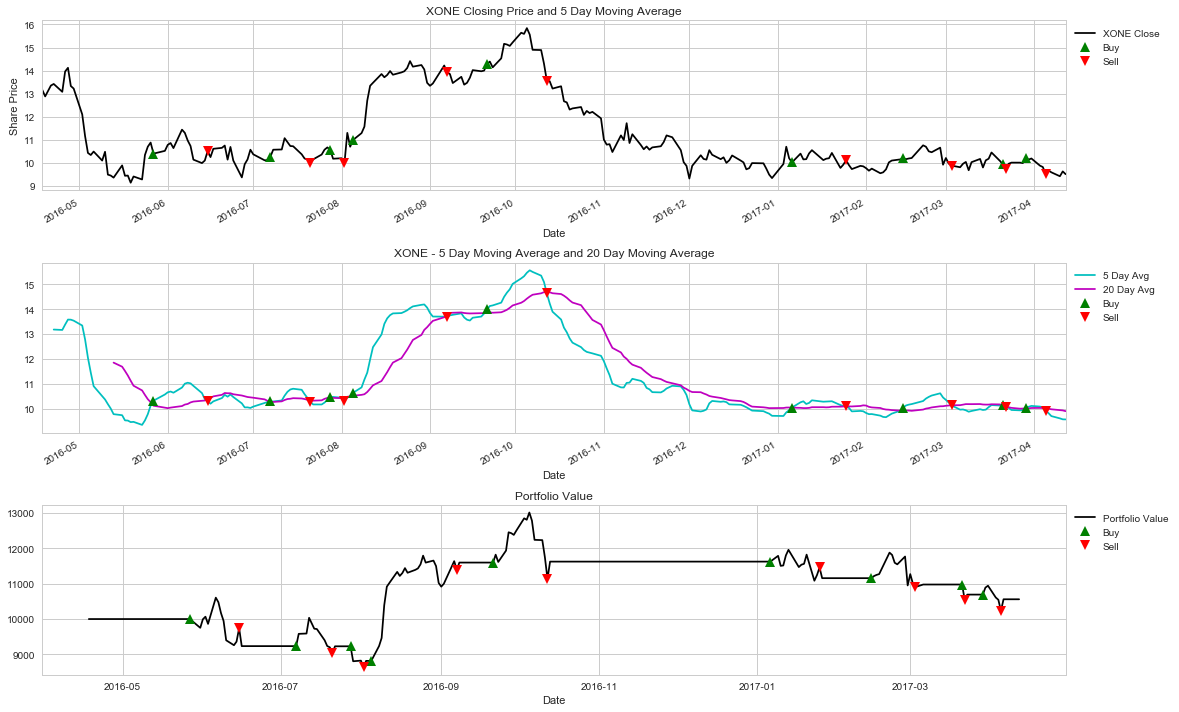

In [36]:
plt.figure(figsize=(15,10))
plt.subplot(311)
Stock_SMA['Close'].plot(label='{} Close'.format(StockName),color='k')
plt.title('{} Closing Price and {} Day Moving Average'.format(StockName,fast))
plt.ylabel('Share Price')
if buy_SMA.empty==0: 
    plt.plot(buy_SMA.index, buy_SMA['Close'], marker='^', markersize=10,linestyle="None",color='g',label='Buy')
if sell_SMA.empty==0: 
    plt.plot(sell_SMA.index, sell_SMA['Close'], marker='v', markersize=10,linestyle="None",color='r',label='Sell')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.subplot(312)
Stock_SMA['Fast SMA'].plot(label='{} Day Avg'.format(fast),color='c')
Stock_SMA['Slow SMA'].plot(label='{} Day Avg'.format(slow),color='m')
plt.title('{} - {} Day Moving Average and {} Day Moving Average'.format(StockName,fast,slow))
if buy_SMA.empty==0: 
    plt.plot(buy_SMA.index, buy_SMA['Fast SMA'], marker='^', markersize=10,linestyle="None",color='g',label='Buy')
if sell_SMA.empty==0: 
    plt.plot(sell_SMA.index, sell_SMA['Fast SMA'], marker='v', markersize=10,linestyle="None",color='r',label='Sell')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.subplot(313)
plt.plot(Stock_SMA['Portfolio'],label='Portfolio Value',color='k')
if buy_SMA.empty==0: 
    plt.plot(buy_SMA.index, buy_SMA['Portfolio'], marker='^', markersize=10,linestyle="None",color='g',label='Buy')
if sell_SMA.empty==0: 
    plt.plot(sell_SMA.index, sell_SMA['Portfolio'], marker='v', markersize=10,linestyle="None",color='r',label='Sell')
plt.title('Portfolio Value'.format(StockName,fast,slow))
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)


plt.tight_layout()
plt.show()

# Leading Trend Following Indicator

## Moving Average Convergence Divergence (MACD)

Setting Expontial Moving Averages (EMA) values. Short EMA, Long EMA, Signal EMA.

In [37]:
EMA_len=[12,26,9]

In [38]:
Stock_MACD=Stock.copy()
New_col=pd.DataFrame(columns=['Buy/Sell','Buy or Sell','Own','Shares','Buying Power'])
Stock_MACD=Stock_MACD.join(New_col)

Initial EMA Calculation

In [39]:
EMA_12=2/(EMA_len[0]+1)*(Stock_MACD['Close'][EMA_len[0]])+(1-2/(EMA_len[0]+1))*Stock_MACD['Close'][0:EMA_len[0]].mean()
EMA_26=2/(EMA_len[1]+1)*(Stock_MACD['Close'][EMA_len[1]])+(1-2/(EMA_len[1]+1))*Stock_MACD['Close'][0:EMA_len[1]].mean()

Determining EMA values

In [40]:
ema12=[]
for i in range(0,len(Stock_MACD['Close'])):
    if i<EMA_len[0]:
        ema12.append(np.nan)
    else:
        ema12.append(EMA_12)
        EMA_12=(2/(EMA_len[0]+1))*Stock_MACD['Close'][i]+(1-2/(EMA_len[0]+1))*EMA_12

In [41]:
ema26=[]
for i in range(0,len(Stock_MACD['Close'])):
    if i<=EMA_len[1]:
        ema26.append(np.nan)
    else:
        ema26.append(EMA_26)
        EMA_26=(2/(EMA_len[1]+1))*Stock_MACD['Close'][i]+(1-2/(EMA_len[1]+1))*EMA_26

In [42]:
Stock_MACD['MACD']=np.array(ema12)-np.array(ema26)

Calculating Initial Signal Value

In [43]:
Signal=2/(EMA_len[2]+1)*(Stock_MACD['MACD'][EMA_len[1]+EMA_len[2]])+(1-2/(EMA_len[2]+1))*Stock_MACD['MACD'][EMA_len[1]:EMA_len[1]+EMA_len[2]].mean()

In [44]:
signal=[]
for i in range(0,len(Stock_MACD['Close'])):
    if i<=EMA_len[1]+EMA_len[2]:
        signal.append(np.nan)
    else:
        signal.append(Signal)
        Signal=(2/(EMA_len[2]+1))*Stock_MACD['MACD'][i]+(1-2/(EMA_len[2]+1))*Signal

In [45]:
Stock_MACD['Signal']=signal

In [46]:
Stock_MACD['MACD_Hist']=(Stock_MACD['MACD']-Stock_MACD['Signal'])

In [47]:
# Positive when FSMA is above SSMA, negative when FSMA is below SSMA
inc_dec_MACD=np.sign(Stock_MACD['MACD_Hist'])
Stock_MACD['Buy/Sell']=np.sign(inc_dec_MACD.diff())

C:\Users\shane\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sign
  
C:\Users\shane\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sign
  This is separate from the ipykernel package so we can avoid doing imports until


In [48]:
buy_sell(Stock_MACD,portfolio_initial_value,commission,stop_loss_percentage)

In [49]:
buy_MACD=Stock_MACD[Stock_MACD['Buy or Sell']==1]
sell_MACD=Stock_MACD[Stock_MACD['Buy or Sell']==-1]

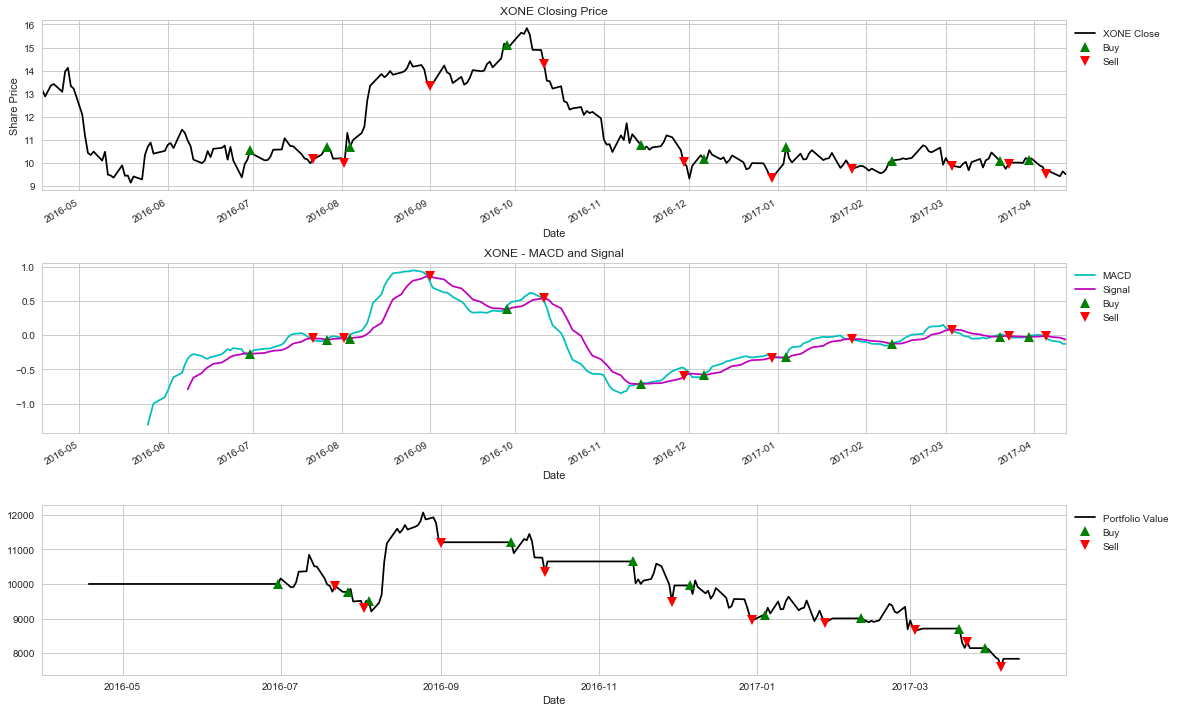

In [50]:
plt.figure(figsize=(15,10))
plt.subplot(311)
Stock_MACD['Close'].plot(label='{} Close'.format(StockName),color='k')
plt.title('{} Closing Price'.format(StockName))
plt.ylabel('Share Price')
if buy_MACD.empty==0: 
    plt.plot(buy_MACD.index, buy_MACD['Close'], marker='^', markersize=10,linestyle="None",color='g',label='Buy')
if sell_MACD.empty==0: 
    plt.plot(sell_MACD.index, sell_MACD['Close'], marker='v', markersize=10,linestyle="None",color='r',label='Sell')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.subplot(312)
Stock_MACD['MACD'].plot(label='MACD',color='c')
Stock_MACD['Signal'].plot(label='Signal',color='m')
plt.title('{} - MACD and Signal'.format(StockName))
if buy_MACD.empty==0: 
    plt.plot(buy_MACD.index, buy_MACD['Signal'], marker='^',markersize=10,linestyle="None",color='g',label='Buy')
if sell_MACD.empty==0: 
    plt.plot(sell_MACD.index, sell_MACD['Signal'], marker='v',markersize=10,linestyle="None",color='r',label='Sell')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.subplot(313)
plt.plot(Stock_MACD['Portfolio'],label='Portfolio Value',color='k')
if buy_MACD.empty==0: 
    plt.plot(buy_MACD.index, buy_MACD['Portfolio'], marker='^', markersize=10,linestyle="None",color='g',label='Buy')
if sell_MACD.empty==0: 
    plt.plot(sell_MACD.index, sell_MACD['Portfolio'], marker='v', markersize=10,linestyle="None",color='r',label='Sell')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.tight_layout()
plt.show()

# Lagging Mean Reversion Indicator

## Bollinger Bands

In [51]:
Stock_BBands=Stock.copy()
New_col=pd.DataFrame(columns=['Buy/Sell','Buy or Sell','Own','Shares','Buying Power'])
Stock_BBands=Stock_BBands.join(New_col)

Typical Price Calculation

In [52]:
h_l_c=(Stock_BBands['High']+Stock_BBands['Low']+Stock_BBands['Close'])/3

In [53]:
twenty_day_avg=h_l_c.rolling(window=20).mean()
twenty_day_std=h_l_c.rolling(window=20).std()

Caluclating Upper and Lower Band

In [54]:
upp_band=twenty_day_avg+2*twenty_day_std
low_band=twenty_day_avg-2*twenty_day_std

Buy and Sell indicators, based on when above or below Bollinger Bands

In [55]:
over=((Stock_BBands['Close']-upp_band).apply(lambda x: x>0))
under=((Stock_BBands['Close']-low_band).apply(lambda x: x<0))

In [56]:
Stock_BBands['Buy/Sell']=under+(-1)*over

In [57]:
buy_sell(Stock_BBands,portfolio_initial_value,commission,stop_loss_percentage)

In [58]:
buy_BBands=Stock_BBands[Stock_BBands['Buy or Sell']==1]
sell_BBands=Stock_BBands[Stock_BBands['Buy or Sell']==-1]

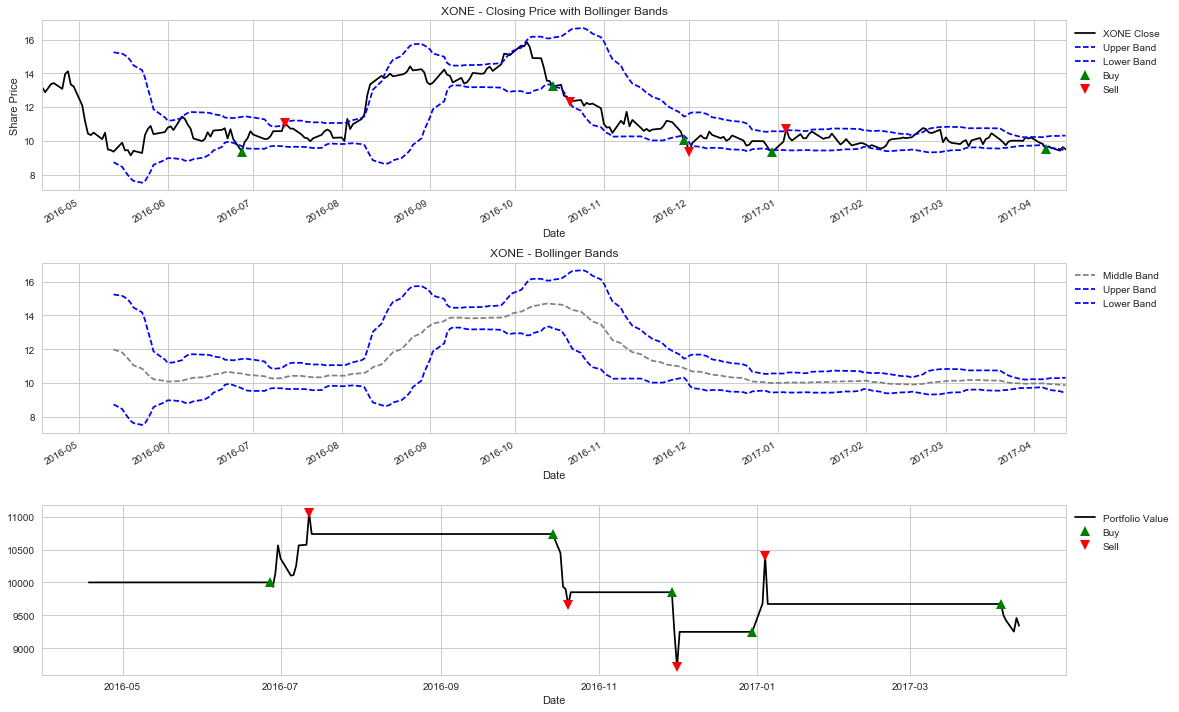

In [59]:
plt.figure(figsize=(15,10))
plt.subplot(311)
Stock_BBands['Close'].plot(label='{} Close'.format(StockName),color='k')
upp_band.plot(label='Upper Band',color='b',linestyle='--')
low_band.plot(label='Lower Band',color='b',linestyle='--')
if buy_BBands.empty==0: 
    plt.plot(buy_BBands.index, buy_BBands['Close'], marker='^',markersize=10,linestyle="None",color='g',label='Buy')
if sell_BBands.empty==0: 
    plt.plot(sell_BBands.index, sell_BBands['Close'], marker='v',markersize=10,linestyle="None",color='r',label='Sell')
plt.title('{} - Closing Price with Bollinger Bands'.format(StockName))
plt.ylabel('Share Price')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.subplot(312)
twenty_day_avg.plot(label='Middle Band',color='Grey',linestyle='--')
upp_band.plot(label='Upper Band',color='b',linestyle='--')
low_band.plot(label='Lower Band',color='b',linestyle='--')
plt.title('{} - Bollinger Bands'.format(StockName))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.subplot(313)
plt.plot(Stock_BBands['Portfolio'],label='Portfolio Value',color='k')
if buy_BBands.empty==0: 
    plt.plot(buy_BBands.index, buy_BBands['Portfolio'], marker='^',markersize=10,linestyle="None",color='g',label='Buy')
if sell_BBands.empty==0: 
    plt.plot(sell_BBands.index, sell_BBands['Portfolio'], marker='v',markersize=10,linestyle="None",color='r',label='Sell')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)


plt.tight_layout()
plt.show()

# Leading Mean Reversion Indicator

## Relative Strength Index (RSI)

Determining changes in closing price

In [60]:
Stock_RSI=Stock.copy()
New_col=pd.DataFrame(columns=['Buy/Sell','Buy or Sell','Own','Shares','Buying Power'])
Stock_RSI=Stock_RSI.join(New_col)

In [61]:
Top_BBand=70
Lower_BBand=30
interval=14

Determing gains and losses on daily basis. Binning gains and losses

In [62]:
diff_close=Stock_RSI['Close'].diff()

rs_pos=diff_close.apply(lambda x : x>0)*diff_close
rs_neg=diff_close.apply(lambda x : x<0)*diff_close*-1

Calulcating initial RS values

In [63]:
rs_positive=rs_pos[0:interval].sum()/interval
rs_negative=rs_neg[0:interval].sum()/interval

Smoothed Average Gain and Average Loss calculation 

In [64]:
rsp=[]
rsn=[]
for i in range(0,len(Stock_RSI['Close'])):
    if i >13:
        rsp.append(rs_positive)
        rsn.append(rs_negative)
        rs_positive=(rs_positive*13+rs_pos[i])/interval
        rs_negative=(rs_negative*13+rs_neg[i])/interval
    else:
        rsp.append(0)
        rsn.append(0)

In [65]:
RS=np.array(rsp)/np.array(rsn)

C:\Users\shane\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [66]:
Stock_RSI['RSI']=100-(100/(1+RS))

In [67]:
# equals 1 when crossing BBAnds
over=((Stock_RSI['RSI']-Top_BBand).apply(lambda x: x>0))
under=((Stock_RSI['RSI']-Lower_BBand).apply(lambda x: x<0))

In [68]:
Stock_RSI['Buy/Sell']=under+(-1)*over

In [69]:
buy_sell(Stock_RSI,portfolio_initial_value,commission,stop_loss_percentage)

In [70]:
buy_RSI=Stock_RSI[Stock_RSI['Buy or Sell']==1]
sell_RSI=Stock_RSI[Stock_RSI['Buy or Sell']==-1]

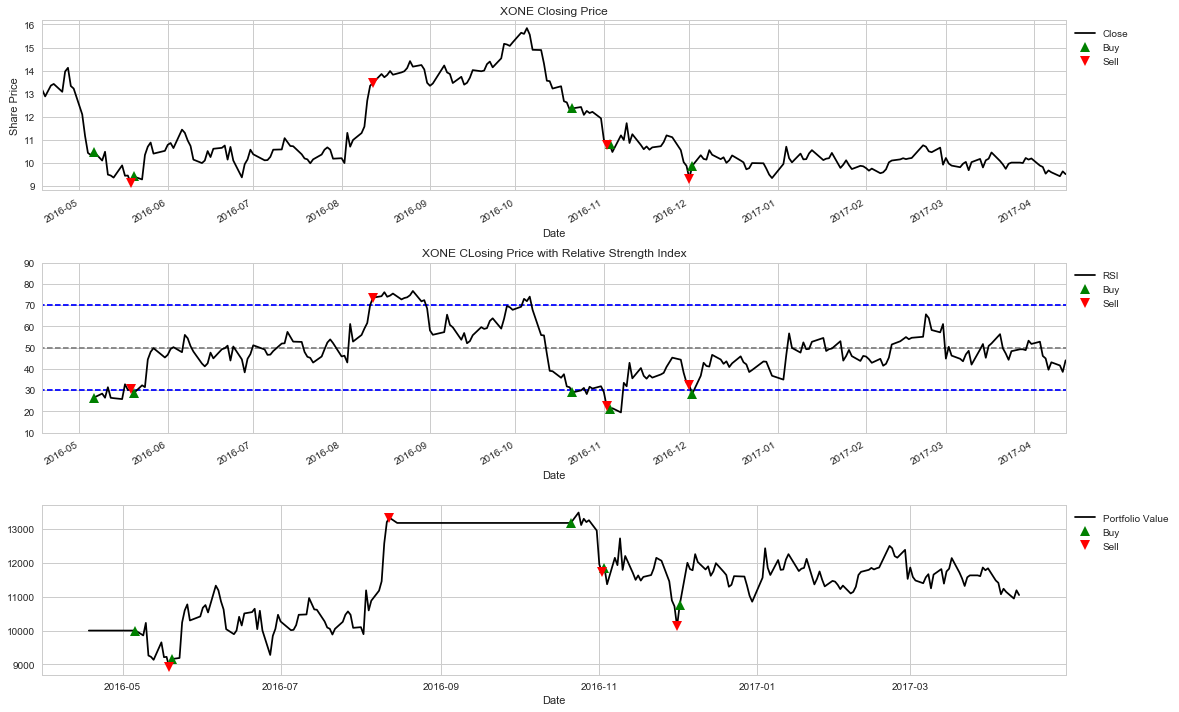

In [71]:
plt.figure(figsize=(15,10))
plt.subplot(311)
Stock_RSI['Close'].plot(label='Close',color='k')
if buy_RSI.empty==0: 
    plt.plot(buy_RSI.index, buy_RSI['Close'], marker='^',markersize=10,linestyle="None",color='g',label='Buy')
if sell_RSI.empty==0: 
    plt.plot(sell_RSI.index, sell_RSI['Close'], marker='v', markersize=10,linestyle="None",color='r',label='Sell')
plt.title('{} Closing Price'.format(StockName))
plt.ylabel('Share Price')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.subplot(312)
plt.title('{} CLosing Price with Relative Strength Index'.format(StockName))
Stock_RSI['RSI'].plot(label='RSI',color='k')
plt.hlines(Top_BBand,start,end, color='b',linestyles='--')
plt.hlines(50,start,end, color='Grey',linestyles='--')
plt.hlines(Lower_BBand,start,end, color='b',linestyles='--')
if buy_RSI.empty==0: 
    plt.plot(buy_RSI.index, buy_RSI['RSI'], marker='^',markersize=10,linestyle="None",color='g',label='Buy')
if sell_RSI.empty==0: 
    plt.plot(sell_RSI.index, sell_RSI['RSI'], marker='v', markersize=10,linestyle="None",color='r',label='Sell')
plt.ylim((10,90))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

plt.subplot(313)
plt.plot(Stock_RSI['Portfolio'],label='Portfolio Value',color='k')
if buy_RSI.empty==0: 
    plt.plot(buy_RSI.index, buy_RSI['Portfolio'], marker='^',markersize=10,linestyle="None",color='g',label='Buy')
if sell_RSI.empty==0: 
    plt.plot(sell_RSI.index, sell_RSI['Portfolio'], marker='v', markersize=10,linestyle="None",color='r',label='Sell')
plt.xlabel('Date')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)


plt.tight_layout()
plt.show()